Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#printing the versions of libraries to be used in this notebook
from platform import python_version
print("python: ",python_version())
print("numpy: ",np.__version__) #numpy version
print("pandas: ",pd.__version__) #pandas version
print("matplotlib: ", matplotlib.__version__) #matplotlib version
print("tensorflow: ",tf.__version__)
print("PIL: ",PIL.__version__)

#printing to check if GPU is being used 
print(tf.config.list_physical_devices('GPU'))

python:  3.8.13
numpy:  1.22.4
pandas:  1.4.2
matplotlib:  3.5.2
tensorflow:  2.9.1
PIL:  9.1.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

file_path = "C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration"
os.chdir(file_path)
cwd = os.getcwd()
print(os.listdir(cwd))

['Test', 'Train']


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
training_folder = '//Train//'
test_folder = '//Test//'

data_dir_train = pathlib.Path(file_path + training_folder)
data_dir_test = pathlib.Path(file_path + test_folder)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)#validation

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              labels = "inferred",
                                                              label_mode = "int",
                                                              batch_size = batch_size,
                                                              image_size = (img_height, img_width),
                                                              seed = 123,
                                                              validation_split = 0.2,
                                                              subset = 'training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              labels = "inferred",
                                                              label_mode = "int",
                                                              batch_size = batch_size,
                                                              image_size = (img_height, img_width),
                                                              seed = 123,
                                                              validation_split = 0.2,
                                                              subset = 'validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

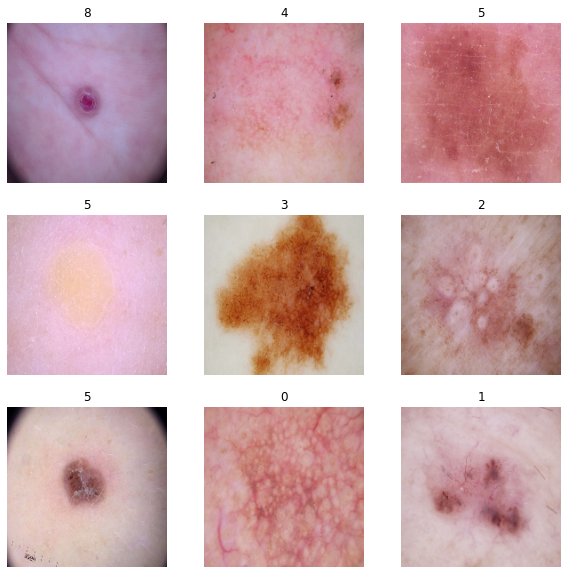

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 59168)             0

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 57ms/step - loss: 2.5541 - accuracy: 0.2729 - val_loss: 1.6769 - val_accuracy: 0.4183
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6640 - accuracy: 0.3996 - val_loss: 1.7863 - val_accuracy: 0.4027
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.5577 - accuracy: 0.4425 - val_loss: 1.4996 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4139 - accuracy: 0.5123 - val_loss: 1.3929 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2417 - accuracy: 0.5569 - val_loss: 1.5515 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 1.1692 - accuracy: 0.5993 - val_loss: 1.5774 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.0229 - accuracy: 0.6401 - val_loss: 1.5127 - val_accuracy: 0.4944
Epoch 8/20
56

### Visualizing training results

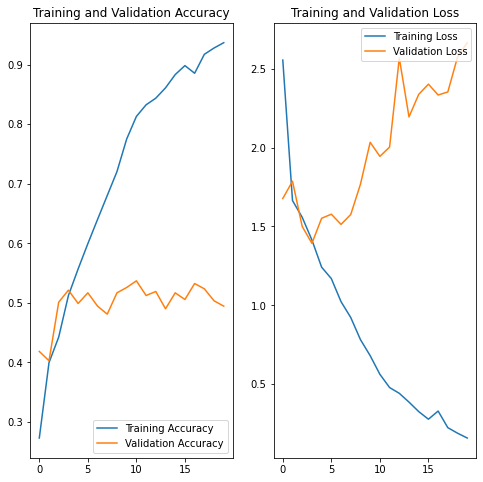

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Question: 
Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Answer:

I have observed overfitting here, as the validation accuracy has not increased, whereas the training accuracy has increased after 3 to 4 epochs. In addiition, the training loss continued to increase after 3 to 4 epochs, and the graphs above indicate a case of overfitting.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3))
  ]
)

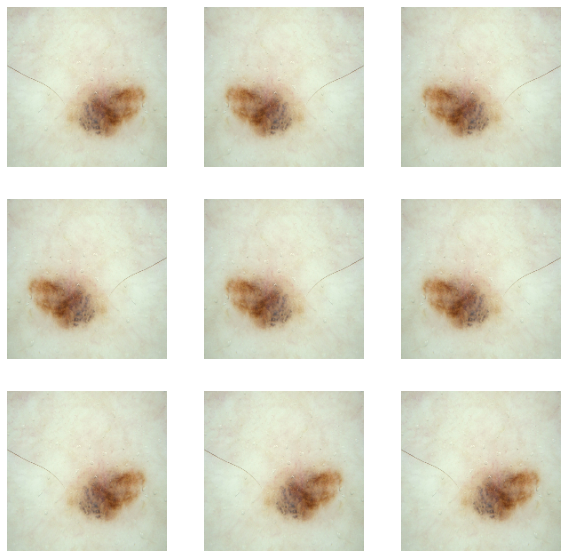

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.models.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])


### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= 20
)

Epoch 1/20
56/56 [==============================] - 6s 90ms/step - loss: 2.6074 - accuracy: 0.2394 - val_loss: 1.7914 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 5s 96ms/step - loss: 1.6795 - accuracy: 0.3945 - val_loss: 1.6259 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5960 - accuracy: 0.4375 - val_loss: 1.4868 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.4947 - accuracy: 0.4682 - val_loss: 1.7128 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 4s 73ms/step - loss: 1.4656 - accuracy: 0.4900 - val_loss: 1.4572 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.3760 - accuracy: 0.5028 - val_loss: 1.4957 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 4s 76ms/step - loss: 1.3485 - accuracy: 0.5179 - val_loss: 1.4478 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing the results

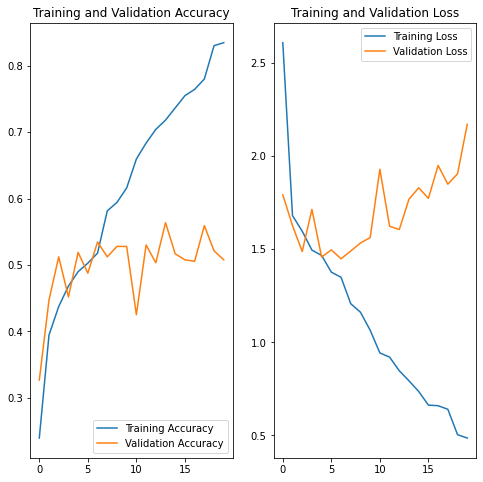

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Question: 
Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Answer:
I see evidences of overfitting, but it was better than the previous model as both training and validation accuracy metrics slowly increased after 5 to 7 epochs. But the validation accuracy stopped increasing any further and validation loss began to increase after 5 to 7 epochs, so overfitting occured during that point. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
from collections import Counter

data_classes = np.concatenate([y for x, y in train_ds], axis=0)

Counter(data_classes)

Counter({5: 370, 3: 352, 1: 309, 8: 115, 2: 77, 4: 277, 0: 92, 7: 142, 6: 58})

#### **Todo:** Write your findings here: 
#### - Question
Which class has the least number of samples?

#### Answer:
Class '6', which stands for seborrheic keratosis.

#### - Which classes dominate the data in terms proportionate number of samples?
Class '5', which stands for pigmented benign keratosis.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
path_to_training_dataset= file_path + training_folder

newpath = file_path + '//New_Train//'

if not os.path.exists(newpath):
    os.makedirs(newpath)

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,  output_directory= newpath + i )
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF3E60CD0>:   4%|▎         | 18/500 [00:00<00:06, 75.67 Samples/s]                  

Initialised with 114 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF5020D30>: 100%|██████████| 500/500 [00:02<00:00, 218.54 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF3E79880>:   1%|▏         | 7/500 [00:00<01:04,  7.66 Samples/s]                  

Initialised with 376 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF505F940>: 100%|██████████| 500/500 [00:02<00:00, 218.94 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22F930CAA60>:   4%|▎         | 18/500 [00:00<00:06, 72.69 Samples/s]                  

Initialised with 95 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//dermatofibroma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x22FF507E850>: 100%|██████████| 500/500 [00:02<00:00, 222.14 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x22FF3E75D00>:   0%|          | 1/500 [00:00<01:01,  8.09 Samples/s]

Initialised with 438 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//melanoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=964x720 at 0x22FF503C2B0>: 100%|██████████| 500/500 [00:10<00:00, 48.03 Samples/s]  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=576x768 at 0x22FF3E42F40>:   0%|          | 2/500 [00:00<00:28, 17.69 Samples/s]  

Initialised with 357 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//nevus.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x22FF5071130>: 100%|██████████| 500/500 [00:10<00:00, 46.96 Samples/s]   
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF3E99610>:   5%|▍         | 24/500 [00:00<00:04, 105.04 Samples/s]                  

Initialised with 462 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF5049F70>: 100%|██████████| 500/500 [00:02<00:00, 184.36 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x22FF3E42700>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x22FF3E81B80>: 100%|██████████| 500/500 [00:06<00:00, 78.43 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF3E83C40>:   3%|▎         | 16/500 [00:00<00:12, 39.49 Samples/s]                  

Initialised with 181 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF3E93BB0>: 100%|██████████| 500/500 [00:02<00:00, 201.80 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FF4FD3310>:   4%|▍         | 22/500 [00:00<00:08, 59.36 Samples/s]                  

Initialised with 139 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//New_Train//vascular lesion.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x22FF3EBA160>: 100%|██████████| 500/500 [00:02<00:00, 194.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
output_directory = pathlib.Path(newpath)
image_count_train = len(list(output_directory.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
import glob 
path_list_new = [x for x in glob.glob(os.path.join(output_directory, '*', '*.jpg'))]
path_list_new

['C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\New_Train\\actinic keratosis\\actinic keratosis_original_ISIC_0025803.jpg_20344b55-cb2c-4fe7-a893-733113d0d4b2.jpg',
 'C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\New_Train\\actinic keratosis\\actinic keratosis_original_ISIC_0025803.jpg_48e7591d-4bcb-4c1e-a1f6-2f923fc26a31.jpg',
 'C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\New_Train\\actinic keratosis\\actinic keratosis_original_ISIC_0025803.jpg_b5207f76-689c-492a-9776-41ad72eda6c1.jpg',
 'C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\New_Train\\actinic keratosis\\actinic keratosis_original_ISIC_0025803.jpg_c88dd5b5-3827-4fb2-bdfd-9755f7b3d8d3.jpg',
 'C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The

In [53]:
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(output_directory, '*', '*.jpg'))]

In [54]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [55]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
df2

,Path,Label
0,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
1,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
2,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
3,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
4,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
...,...,...
4495,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,vascular lesion
4496,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,vascular lesion
4497,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,vascular lesion
4498,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,vascular lesion


In [56]:
#new_df['Label'].value_counts()
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [57]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [58]:
data_dir_train= newpath
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [59]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [60]:
## your code goes here
model = tf.keras.models.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [61]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [62]:
final_epochs = 30
## Your code goes here, use 30 epochs.
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= final_epochs
)# your model fit code

Epoch 1/50
113/113 [==============================] - 10s 83ms/step - loss: 2.3957 - accuracy: 0.2494 - val_loss: 1.7534 - val_accuracy: 0.3111
Epoch 2/50
113/113 [==============================] - 10s 82ms/step - loss: 1.5595 - accuracy: 0.4083 - val_loss: 1.5006 - val_accuracy: 0.4300
Epoch 3/50
113/113 [==============================] - 10s 82ms/step - loss: 1.4089 - accuracy: 0.4672 - val_loss: 1.4273 - val_accuracy: 0.4333
Epoch 4/50
113/113 [==============================] - 10s 83ms/step - loss: 1.2152 - accuracy: 0.5542 - val_loss: 1.4229 - val_accuracy: 0.4889
Epoch 5/50
113/113 [==============================] - 10s 84ms/step - loss: 1.0805 - accuracy: 0.6178 - val_loss: 1.3368 - val_accuracy: 0.5111
Epoch 6/50
113/113 [==============================] - 10s 83ms/step - loss: 0.9151 - accuracy: 0.6769 - val_loss: 1.1371 - val_accuracy: 0.5844
Epoch 7/50
113/113 [==============================] - 10s 85ms/step - loss: 0.7625 - accuracy: 0.7283 - val_loss: 1.1105 - val_accuracy:

#### **Todo:**  Visualize the model results

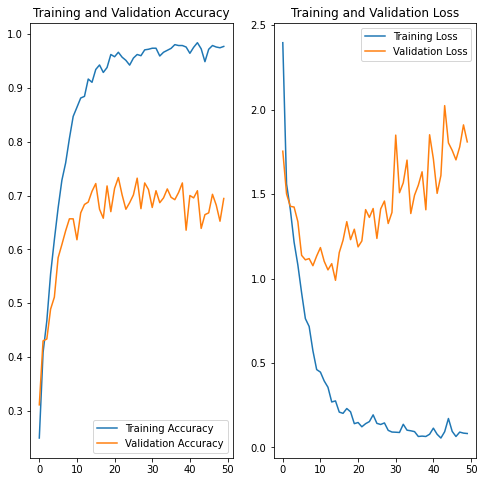

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(final_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question:** 
Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Answer:

Unfortuntely I did not get rid of underfitting or overfitting, and the model with the class rebalances has overfitted but I did find the class rebalancing algorithm helpful with higher validation accuracy above 70% around 10 to 15 epochs.

The higher validation accuracy means that the model with the data augmentation is a better model than the previous two models.

Personally, I am not a fan of rebalancing class by oversampling a data with fewer samples.
We need to find find more data and add to a class with fewer samples as much as possible because oversampling will not help to have a wider variance in data, as we are just repeating the same data.
We need to do more augmentation, but it may not be help the situation. 